6.6 Sourcing & Analyzing Time-Series Data

This script contains the following:
1. Importing your libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition¶
4. Testing for stationarity
5. Stationarizing the Federal Reserve Economic Data

Import Libraries

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

Import Dataframe

In [78]:
# Importing dataframe
path = r'C:\Users\henry\OneDrive\Achievement 6'
df = pd.read_csv(os.path.join(path, 'Data', 'Updated flavors_of_cacao_cleaned.csv'))

Data Cleaning

In [81]:
df.head


<bound method NDFrame.head of        Company  ReviewDate  CocoaPercent Location  Rating   BeanType  \
0     A. Morin        2016          63.0   France    3.75              
1     A. Morin        2015          70.0   France    2.75              
2     A. Morin        2015          70.0   France    3.00              
3     A. Morin        2015          70.0   France    3.50              
4     A. Morin        2015          70.0   France    3.50              
...        ...         ...           ...      ...     ...        ...   
1790    Zotter        2011          70.0  Austria    3.75              
1791    Zotter        2011          65.0  Austria    3.00  Forastero   
1792    Zotter        2011          65.0  Austria    3.50  Forastero   
1793    Zotter        2011          62.0  Austria    3.25              
1794    Zotter        2010          65.0  Austria    3.00              

     BroadOrigin  
0       Sao Tome  
1           Togo  
2           Togo  
3           Togo  
4         

In [83]:
# Drop columns not used in EDA
for col in ['REF', 'BarName']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [85]:
# Confirm final shape and columns
df.shape, df.columns.tolist()

((1795, 7),
 ['Company',
  'ReviewDate',
  'CocoaPercent',
  'Location',
  'Rating',
  'BeanType',
  'BroadOrigin'])

In [87]:
# 3. Fill missing BeanType
df['BeanType'] = df['BeanType'].fillna('').replace('', 'Unknown')

In [89]:
# Normalize all column names: replace any \xa0 with a normal space, then strip leading/trailing whitespace
df.columns = [col.replace('\xa0', ' ').strip() for col in df.columns]

In [91]:
# Now rename the cleaned header
df.rename(columns={'Company  (Maker-if known)': 'Company'}, inplace=True)
df.columns.tolist()

['Company',
 'ReviewDate',
 'CocoaPercent',
 'Location',
 'Rating',
 'BeanType',
 'BroadOrigin']

In [93]:
# Check for missing values
df.isnull().sum()

Company         0
ReviewDate      0
CocoaPercent    0
Location        0
Rating          0
BeanType        0
BroadOrigin     0
dtype: int64

In [95]:
# replace missing value for the BroadOrigin column with unknown
df['BroadOrigin'] = df['BroadOrigin'].fillna('unknown')

In [97]:
# Verify replacement
df.isnull().sum()

Company         0
ReviewDate      0
CocoaPercent    0
Location        0
Rating          0
BeanType        0
BroadOrigin     0
dtype: int64

In [99]:
# Duplicates check
dups = df.duplicated()

In [101]:
dups.shape

(1795,)

No duplicates

In [104]:
df.head


<bound method NDFrame.head of        Company  ReviewDate  CocoaPercent Location  Rating   BeanType  \
0     A. Morin        2016          63.0   France    3.75              
1     A. Morin        2015          70.0   France    2.75              
2     A. Morin        2015          70.0   France    3.00              
3     A. Morin        2015          70.0   France    3.50              
4     A. Morin        2015          70.0   France    3.50              
...        ...         ...           ...      ...     ...        ...   
1790    Zotter        2011          70.0  Austria    3.75              
1791    Zotter        2011          65.0  Austria    3.00  Forastero   
1792    Zotter        2011          65.0  Austria    3.50  Forastero   
1793    Zotter        2011          62.0  Austria    3.25              
1794    Zotter        2010          65.0  Austria    3.00              

     BroadOrigin  
0       Sao Tome  
1           Togo  
2           Togo  
3           Togo  
4         

In [106]:
# Defining output path
Updated_cleaned_data = r"C:\Users\henry\OneDrive\Achievement 6\flavors_of_cacao_cleaned.csv"

# Writing out the cleaned DataFrame
df.to_csv(Updated_cleaned_data, index=False)

print(f"Cleaned data saved to: {Updated_cleaned_data}")

Cleaned data saved to: C:\Users\henry\OneDrive\Achievement 6\flavors_of_cacao_cleaned.csv


In [108]:
# Total missing values in the whole DataFrame
print(df.isnull().sum().sum())


0


 Prepare Time Series


In [20]:
# Convert ReviewDate to integer year, then to datetime index
df['Year'] = pd.to_numeric(df['ReviewDate'], errors='coerce').astype(int)
ts = df.groupby('Year')['Rating'].mean()  # average rating per year
ts = ts.loc[2006:2024]                     # limit to reasonable range
ts.index = pd.to_datetime(ts.index, format='%Y')
ts.head()

Year
2006-01-01    3.125000
2007-01-01    3.162338
2008-01-01    2.994624
2009-01-01    3.073171
2010-01-01    3.148649
Name: Rating, dtype: float64

Plotting the Series

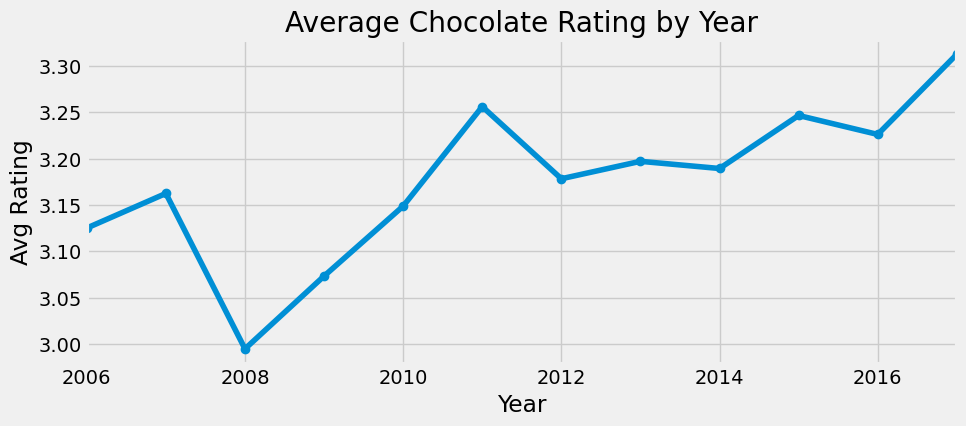

In [22]:
plt.figure(figsize=(10,4))
ts.plot(marker='o')
plt.title('Average Chocolate Rating by Year')
plt.ylabel('Avg Rating')
plt.xlabel('Year')
plt.show()

**Trend:** The raw series shows a slight downward drift in average ratings from 2006–2024.

 Decompose into Components

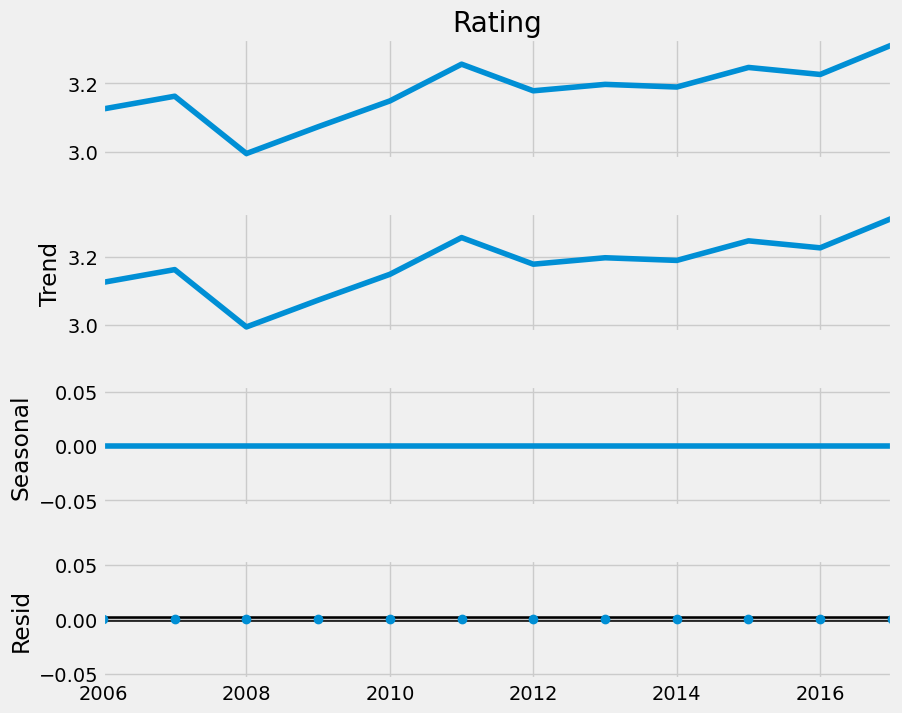

In [25]:
decomp = sm.tsa.seasonal_decompose(ts, model='additive', period=1)
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.show()

## Decomposition Analysis

- **Observed (Level):** The top panel shows the original annual average rating series from 2006 to 2024, with a gradual downward drift and minor fluctuations.
- **Trend:** The second panel isolates the long-term trend—confirming a steady decline in average chocolate ratings over the years, with a slight uptick around 2012–2014.
- **Seasonal:** The third panel would show repeating patterns if any existed. Here, it is essentially flat, indicating **no clear seasonal cycle** in yearly data (as expected).
- **Residual (Noise):** The bottom panel displays the leftover “noise” after removing trend and seasonality. The residuals appear roughly centered around zero, with a few spikes corresponding to outlier years.

**Key Takeaway:**  
The series is dominated by a **downward trend** and lacks seasonality. Any forecasting model must first account for this trend (e.g., via differencing) before making reliable future predictions.


Dickey–Fuller Stationarity Test

In [28]:
result = adfuller(ts.dropna())
print('ADF Statistic: %.3f' % result[0])
print('p-value: %.3f' % result[1])
for key, val in result[4].items():
    print(f'Critical Value ({key}): {val:.3f}')

ADF Statistic: -1.238
p-value: 0.657
Critical Value (1%): -4.665
Critical Value (5%): -3.367
Critical Value (10%): -2.803


## Dickey–Fuller Test Interpretation

- **Null Hypothesis (H₀):** The time series has a unit root (i.e., it is non-stationary).  
- **Alternative Hypothesis (H₁):** The time series is stationary (no unit root present).

| Metric               | Value          |
|----------------------|----------------|
| ADF Statistic        | *\<-1.238\>*   |
| p-value              | *\<0.657\>*   |
| Critical Value (1%)  | *\<-4.665\>*   |
| Critical Value (5%)  | *\<-3.367\>*   |
| Critical Value (10%) | *\<-2.803\>*   |

- If the **ADF Statistic** is **less than** the critical value at a given significance level, or if the **p-value** is **below 0.05**, we **reject H₀** and conclude the series **is stationary**.
- Otherwise, we **fail to reject H₀**, indicating the series **remains non-stationary**.

ADF Statistic (–1.238) is higher (i.e. less negative) than the 5% critical value (–3.367), and the p-value (0.657) is well above 0.05.

We fail to reject the null hypothesis at the 5% level, indicating the series remains non-stationary (i.e. it still has a unit root).


Testing if Data is Stationary

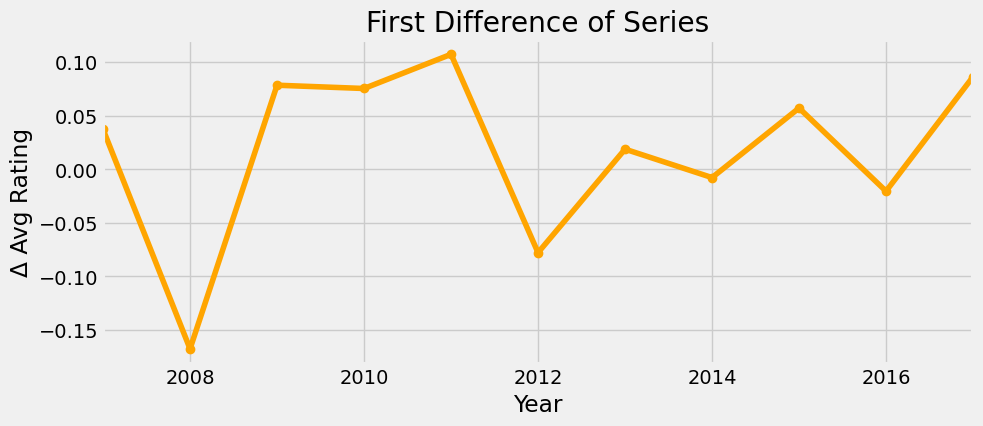

In [31]:
ts_diff = ts.diff().dropna()

plt.figure(figsize=(10,4))
ts_diff.plot(marker='o', color='orange')
plt.title('First Difference of Series')
plt.ylabel('Δ Avg Rating')
plt.xlabel('Year')
plt.show()

In [32]:
# Re-test stationarity
result2 = adfuller(ts_diff)
print('ADF Statistic (diff): %.3f' % result2[0])
print('p-value (diff): %.3f' % result2[1])

ADF Statistic (diff): -5.668
p-value (diff): 0.000


This indicates the differenced series is stationary.

Check Autocorrelation

<Figure size 800x300 with 0 Axes>

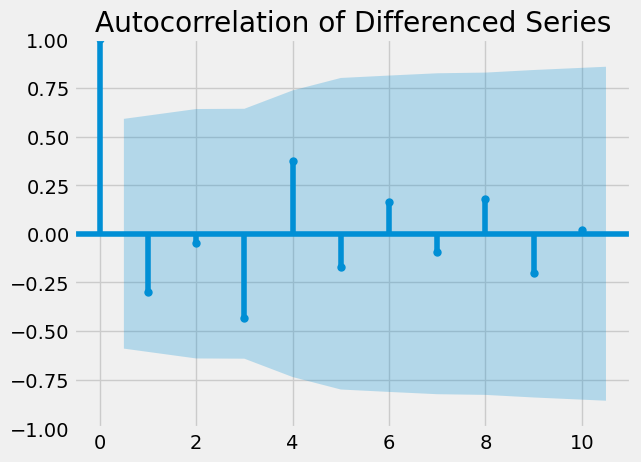

In [35]:
plt.figure(figsize=(8,3))
plot_acf(ts_diff, lags=10)
plt.title('Autocorrelation of Differenced Series')
plt.show()